In [ ]:
import zipfile
import json
import io
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from io import BytesIO
import os
import warnings

from torch.utils.data import Dataset
import torch
from open_flamingo import create_model_and_transforms
import torch.nn as nn


c:\Users\Mert\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Dataset_1: **MMHS150K**

In [2]:
# Relative path to the ZIP file
zip_path = "../external_data/MMHS150K.zip"
json_filename = "MMHS150K_GT.json"  # Ensure this matches the file inside the ZIP

# Open the ZIP file and read the JSON
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    with zip_file.open(json_filename) as json_file:
        data = json.load(json_file)

In [3]:

# Relative path to the ZIP file and the JSON file name inside the ZIP
zip_path = "../external_data/MMHS150K.zip"
json_filename = "MMHS150K_GT.json"  # Ensure this matches the file inside the ZIP

# Open the ZIP file and combine JSON loading with image processing
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # Load the JSON ground-truth data
    with zip_file.open(json_filename) as json_file:
        gt_data = json.load(json_file)
    
    # List the image files in the 'img_resized/' directory (ignoring subdirectories)
    image_files = [f for f in zip_file.namelist() if f.startswith("img_resized/") and not f.endswith("/")]
    # Get the first 20 images
    first_20_images = image_files[:20]
    
    images = []
    annotations = []
    image_ids = []  # This list will store the image/tweet IDs
    for file in first_20_images:
        # Extract the basename to get the image_id (tweet ID)
        image_id = file.split("/")[-1]
        image_ids.append(image_id)
        
        # Get annotation from JSON using the image_id
        annotation = gt_data.get(image_id, "No annotation")
        annotations.append(annotation)
        
        # Open and read the image file from the ZIP archive
        with zip_file.open(file) as image_file:
            image_data = image_file.read()
            image = Image.open(io.BytesIO(image_data))
            images.append(image)

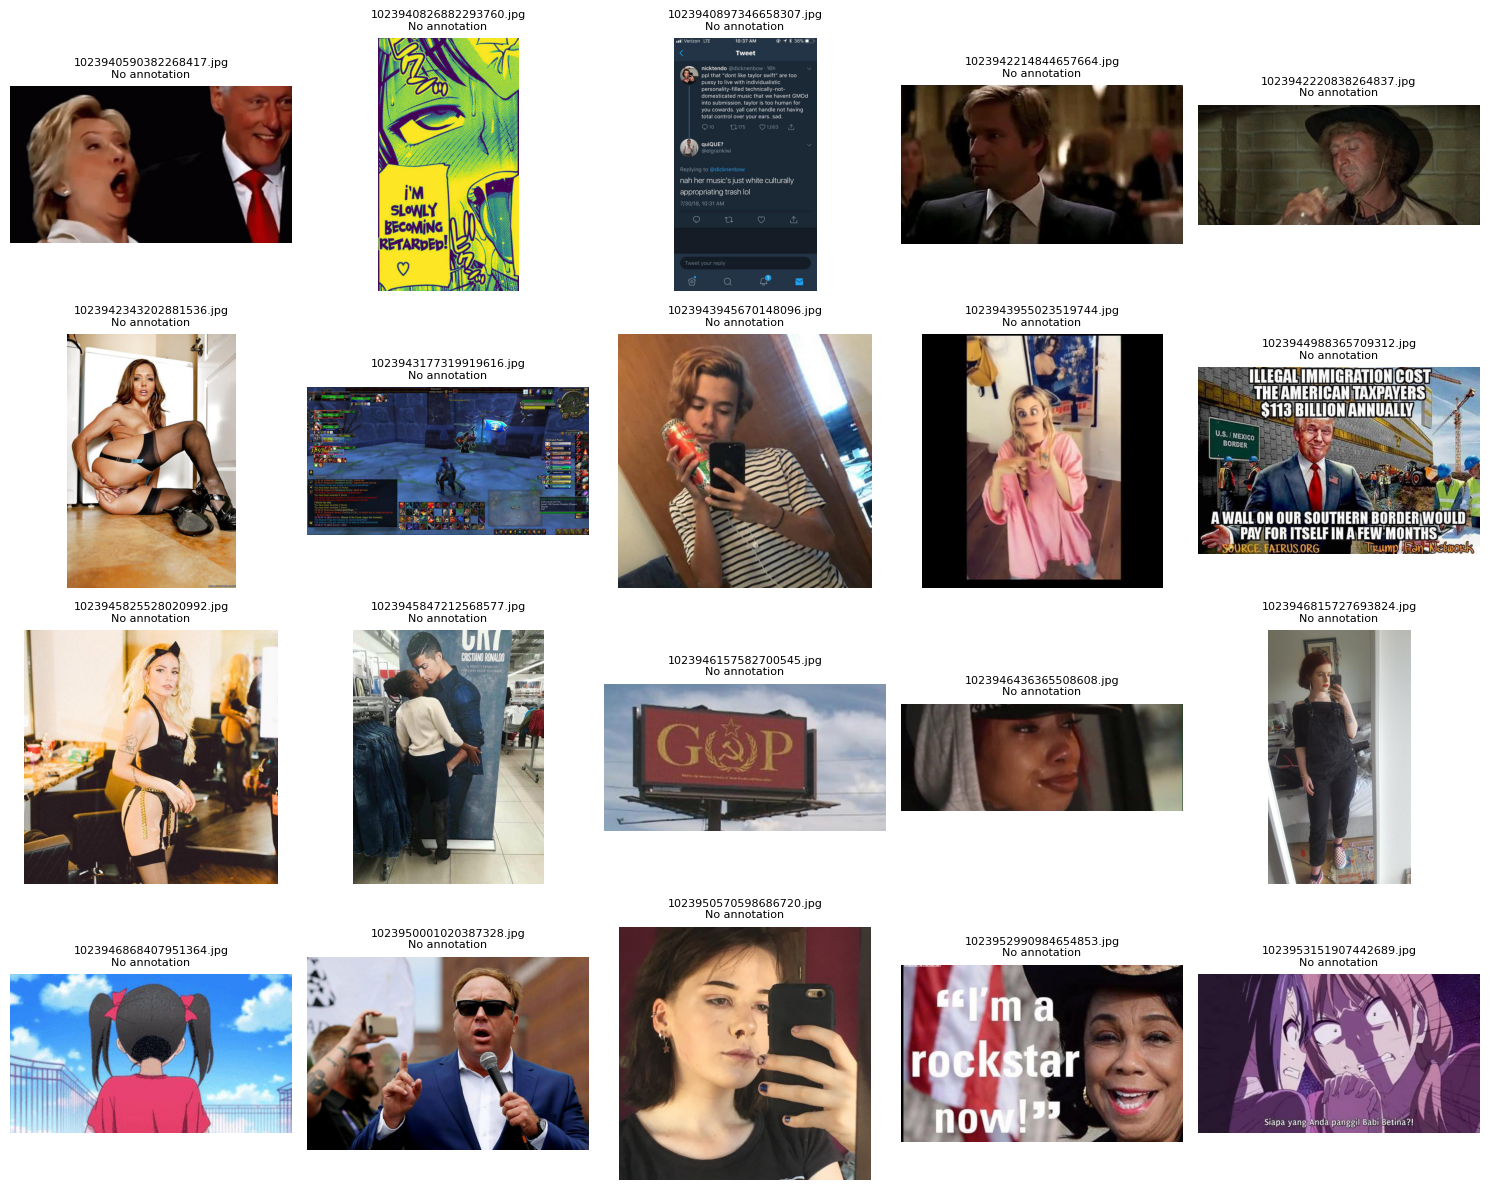

In [4]:
# Plot the images along with their annotations
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for ax, img, annot, img_id in zip(axes, images, annotations, image_ids):
    ax.imshow(img)
    # Optionally include the image_id in the title to see the tweet id
    ax.set_title(f"{img_id}\n{annot}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [5]:
mm_df = (
    pd.DataFrame(data)
    .T
    .reset_index()
    .rename(columns={"index": "img_id"})
    .assign(
        # Normalize label strings: everything except 'NotHate' becomes 'Hate'
        labels_str=lambda df: df["labels_str"].apply(
            lambda x: ['NotHate' if label == 'NotHate' else 'Hate' for label in x] if isinstance(x, list) else x
        ),
        label_counts=lambda df: df["labels_str"].apply(
            lambda x: dict(Counter(x)) if x else {}
        ),
        dominant_label=lambda df: df["label_counts"].apply(
            lambda d: (
                max(d, key=lambda k: d[k])
                if d and list(d.values()).count(max(d.values())) == 1
                else None
            )
        )
    )
    [["img_id", "tweet_text", "labels_str", "label_counts", "dominant_label"]]
)

# Function to validate each row in 'labels_str'
def is_valid_label_list(label_list):
    return all(label in {"NotHate", "Hate"} for label in label_list) if isinstance(label_list, list) else False



All labels are either 'NotHate' or 'Hate': True
Number of missing values in 'dominant label':  0


<Axes: xlabel='label'>

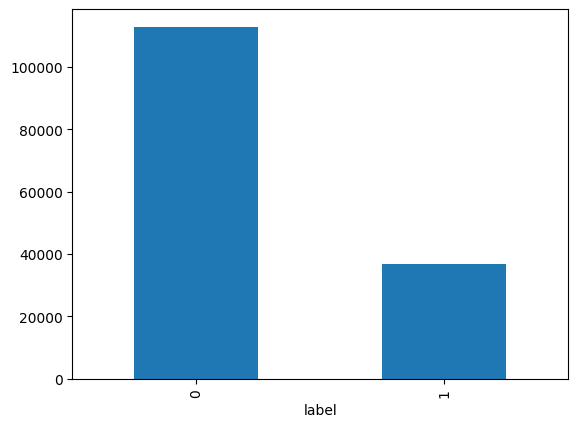

In [ ]:
# Apply the check and see if all rows pass
all_valid = mm_df["labels_str"].apply(is_valid_label_list).all()

print("All labels are either 'NotHate' or 'Hate':", all_valid)

mm_df_cleaned = mm_df.dropna(subset=["dominant_label"]).copy()  # <--- Added .copy()

print("Number of missing values in 'dominant label': ", mm_df_cleaned["dominant_label"].isna().sum())

# Encoding the labels to binary values
mm_df_cleaned["dominant_label"] = mm_df_cleaned["dominant_label"].apply(lambda x: 1 if x == "Hate" else 0)

#Selecting the relevant columns
mm_df_cleaned = mm_df_cleaned[["img_id", "tweet_text", "dominant_label"]].rename(columns = {'tweet_text': 'text', 'dominant_label': 'label'})
mm_df_cleaned["label"].value_counts().plot(kind = "bar") #unbalanced dataset



#### An example: **Tweet and image pair**

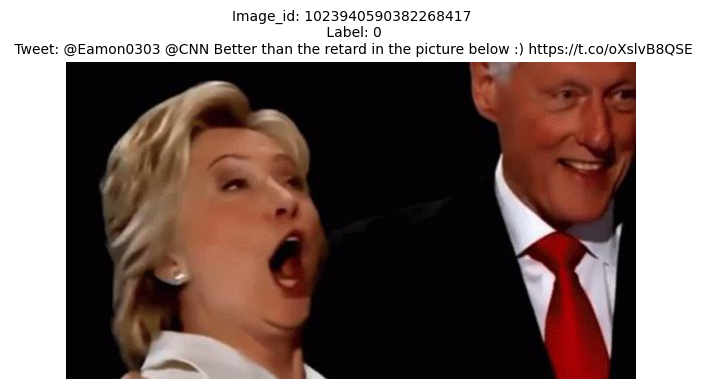

In [10]:
# Target image ID
target_id = "1023940590382268417"

# Get tweet text and label
tweet_text = mm_df_cleaned[mm_df_cleaned["img_id"] == target_id]["text"].values[0]
label = mm_df_cleaned[mm_df_cleaned["img_id"] == target_id]["label"].values[0]

# Construct image file path inside ZIP
image_filename = f"img_resized/{target_id}.jpg"

# Read and display the image
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    with zip_file.open(image_filename) as img_file:
        img = Image.open(BytesIO(img_file.read())).convert("RGB")

# Plot the image with annotation
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Image_id: {target_id}\n Label: {label}\n Tweet: {tweet_text}", fontsize=10)
plt.axis("off")
plt.tight_layout()
plt.show()


In [11]:
# Define output path
output_dir = "..\data\processed\MMHS150K_processed"
os.makedirs(output_dir, exist_ok=True)

# Save cleaned DataFrame as CSV
csv_path = os.path.join(output_dir, "MMHS150K_cleaned.csv")
mm_df_cleaned.to_csv(csv_path, index=False)

#To observe the data format
print(mm_df_cleaned.head())

# Print the image IDs for reference
print("Image IDs:", image_ids[:5])

print("Images: ",images[:5])

                img_id                                               text  \
0  1114679353714016256       @FriskDontMiss Nigga https://t.co/cAsaLWEpue   
1  1063020048816660480     My horses are retarded https://t.co/HYhqc6d5WN   
2  1108927368075374593  “NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...   
3  1114558534635618305  RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...   
4  1035252480215592966  “EVERYbody calling you Nigger now!” https://t....   

   label  
0      1  
1      1  
2      0  
3      0  
4      1  
Image IDs: ['1023940590382268417.jpg', '1023940826882293760.jpg', '1023940897346658307.jpg', '1023942214844657664.jpg', '1023942220838264837.jpg']
Images:  [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=898x500 at 0x2915A43FFD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=500x901 at 0x2915596C4D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x2917D81F510>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x29

#### Pre-training **Flamingo**

In [17]:
# Define the dataset class for MMHS150K

class MMHS150KDataset(Dataset):
    def __init__(self, csv_path, image_dir, image_processor, tokenizer):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.image_processor = image_processor
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(f"{self.image_dir}/{row['img_id']}.jpg")
        text = row["text"]
        label = row["label"]

        # Preprocess image (CLIP ViT)
        # because Flamingo uses CLIP's Vision Transformer (ViT) as its vision encoder to process images
        pixel_values = self.image_processor(image).unsqueeze(0)  # Add batch dimension

        # Tokenize text (add Flamingo's special tokens)

        inputs = self.tokenizer(
            f"<image>{text}",  # Wrap text with image tokens
            return_tensors="pt",
            padding="max_length",
            max_length=128,
            truncation=True,
        )
        return {
            "pixel_values": pixel_values,
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.float32),
        }

    def __len__(self):
        return len(self.data)

In [2]:


# Initialize Flamingo
model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",  # CLIP encoder
    clip_vision_encoder_pretrained="openai",  # Pretrained weights
    lang_encoder_path="anas-awadalla/mpt-1b-redpajama-200b",  # Language model
    tokenizer_path="anas-awadalla/mpt-1b-redpajama-200b",  # Tokenizer
    cross_attn_every_n_layers=1,
)


c:\Users\Mert\anaconda3\Lib\site-packages\open_clip\factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
c:\Users\Mert\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\Mert\anaconda3\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.unty

You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


c:\Users\Mert\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Flamingo model initialized with 1046992944 trainable parameters


In [ ]:
# Replace Flamingo's head with a classifier
model.classifier = nn.Sequential(
    nn.Linear(model.lang_encoder.config.d_model, 1),  # Use d_model instead of hidden_size
    nn.Sigmoid()
)

In [ ]:
from torch.utils.data import DataLoader
import torch

# Load dataset
dataset = MMHS150KDataset(
    csv_path="mmhs150k/labels.csv",
    image_dir="mmhs150k/images",
    image_processor=image_processor,
    tokenizer=tokenizer,
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

def loss_fn(dataset):
    labels = dataset.data["label"]
    num_pos = sum(labels)
    num_neg = len(labels) - num_pos
    pos_weight = num_neg / num_pos if num_pos > 0 else 1.0
    
    
loss_fn = nn.BCELoss()

# Train
model.train()
for epoch in range(3):
    for batch in dataloader:
        outputs = model(
            vision_x=batch["pixel_values"].unsqueeze(1),  # Add batch dim
            lang_x=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        )
        logits = outputs.logits[:, -1, :]  # Last token for classification
        loss = loss_fn(logits.squeeze(), batch["labels"])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Loss: {loss.item()}")